In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import category_encoders as ce # импорт для работы с кодировщиком
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.downloader.download('vader_lexicon')

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
import plotly.express as px

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/user/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
# !pip freeze > kaggle_requirements.txt
!pip freeze > local_venv_requirements.txt

In [4]:
# Подгрузим наши данные из соревнования

# DATA_DIR = '/kaggle/input/sf-booking/'
# df_train = pd.read_csv(DATA_DIR + '/hotels_train.csv') # датасет для обучения
df_train = pd.read_csv('hotels_train.csv.zip')
# df_test = pd.read_csv(DATA_DIR + '/hotels_test.csv') # датасет для предсказания
df_test = pd.read_csv('hotels_test.csv.zip')
# sample_submission = pd.read_csv(DATA_DIR + '/submission.csv') # самбмишн
sample_submission = pd.read_csv('submission.csv')

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [6]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [8]:
df_test.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443


In [9]:
sample_submission.head(2)

,reviewer_score,id
0,8.685,488440
1,7.578,274649


In [10]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   reviewer_score  128935 non-null  float64
 1   id              128935 non-null  int64  
dtypes: float64(1), int64(1)
memory usage: 2.0 MB


In [11]:
# ВАЖНО! для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = pd.concat([df_train, df_test], sort=False, ignore_index=True)#.reset_index(drop=True) # объединяем

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

# ОБРАБОТКА ДАТАСЕТА

In [13]:
# data['lat'] = data['lat'].fillna(0) # Заполняем пропуски нулями
# data['lng'] = data['lng'].fillna(0)

In [14]:
data = data.drop('lat', axis=1) # Удаляем координаты
data = data.drop('lng', axis=1)

### Поищем дубликаты в датасете

In [15]:
data.duplicated().value_counts()

False    515402
True        336
Name: count, dtype: int64

Дубликатов в датасете 336, но мы не можем их удалить т.к. тест не будет совпадать с сабмитом.

### Посмотрим на корреляцию.

In [16]:
data.corr(numeric_only=True).round(3)

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,sample
additional_number_of_scoring,1.000,-0.153,0.029,0.825,-0.053,-0.072,-0.019,0.001
average_score,-0.153,1.000,-0.112,-0.180,0.107,0.036,0.114,-0.001
review_total_negative_word_counts,0.029,-0.112,1.000,0.035,0.120,0.003,-0.121,-0.000
total_number_of_reviews,0.825,-0.180,0.035,1.000,-0.030,-0.025,-0.023,0.000
review_total_positive_word_counts,-0.053,0.107,0.120,-0.030,1.000,0.027,0.069,0.000
total_number_of_reviews_reviewer_has_given,-0.072,0.036,0.003,-0.025,0.027,1.000,0.002,0.002
reviewer_score,-0.019,0.114,-0.121,-0.023,0.069,0.002,1.000,0.932
sample,0.001,-0.001,-0.000,0.000,0.000,0.002,0.932,1.000


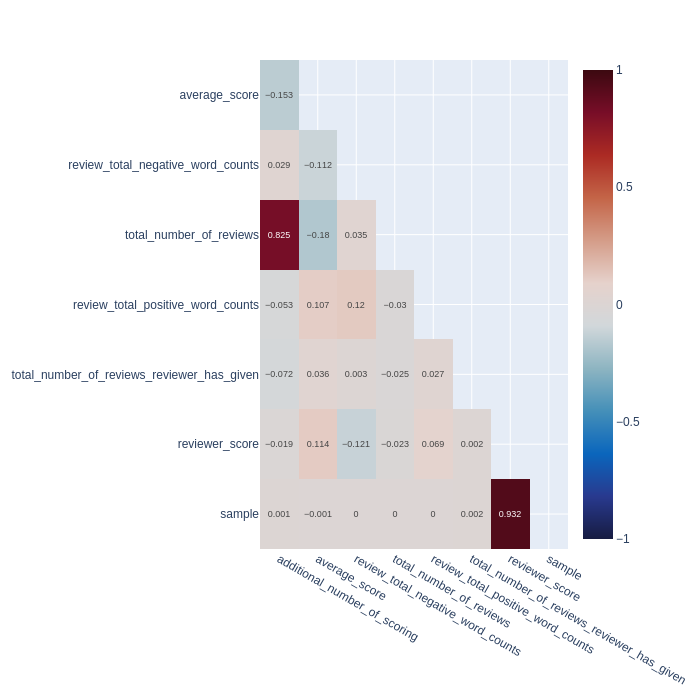

In [17]:
df_corr = data.corr(numeric_only=True).round(3)
# Mask to matrix
mask = np.zeros_like(df_corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
# Viz
df_corr_viz = df_corr.mask(mask).dropna(how='all').dropna(how='all')
fig = px.imshow(df_corr_viz,
                text_auto=True,
                height=700,
                color_continuous_scale='balance',
                aspect="auto",
                zmin=-1,
                zmax=1
                )
fig.show('png');

Наблюдается сильная корреляция между признаками total_number_of_reviews и additional_number_of_scoring. Нужно удалить один из них.

### Удалим признак additional_number_of_scoring.

In [18]:
data = data.drop('additional_number_of_scoring', axis=1)
data.head(4)

,hotel_address,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,sample
0,Stratton Street Mayfair Westminster Borough Lo...,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,1
1,130 134 Southampton Row Camden London WC1B 5AF...,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,1
2,151 bis Rue de Rennes 6th arr 75006 Paris France,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,1
3,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,9/22/2015,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,11,8,10.0,"[' Leisure trip ', ' Solo traveler ', ' Standa...",681 day,1


### удалим признак days_since_review
Поскольку мы не привязаны к какому либо времянному ряду, будет логичным не оценивать этот признак.

In [19]:
data = data.drop('days_since_review', axis=1)

### Обработка даты
От даты написания отзыва оставим только месяц. Поскольку мы не привязаны к какому либо временному промежутку, но может прослеживаться различный характер отзывов в зависимости от времени года.

In [20]:
data['review_date'] = pd.to_datetime(data['review_date'])  # Преобразуем признак в формат даты.
data['review_date_month'] = pd.DatetimeIndex(data['review_date']).month # Оставим только месяц.
data= data.drop('review_date', axis=1) # Удалим исходный столбец.
data.shape

(515738, 14)

In [21]:
#обработаем месяцы OneHotEncoderom, создав 12 новых признаков в бинарном формате.
encoder = ce.OneHotEncoder(cols=['review_date_month']) # указываем столбец для кодирования.
type_bin = encoder.fit_transform(data['review_date_month'])
data = pd.concat([data, type_bin], axis=1).reset_index()
data = data.drop('review_date_month', axis=1)
data.shape

/home/user/anaconda3/envs/PROJECT-3_EDA_FE/lib/python3.11/site-packages/category_encoders/ordinal.py:198: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/home/user/anaconda3/envs/PROJECT-3_EDA_FE/lib/python3.11/site-packages/category_encoders/ordinal.py:198: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/home/user/anaconda3/envs/PROJECT-3_EDA_FE/lib/python3.11/site-packages/category_encoders/ordinal.py:198: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_object

(515738, 26)

### Стандартизируем числовые признаки

In [22]:
col_name= data[['average_score',
                'review_total_negative_word_counts',
                'review_total_positive_word_counts',
                'total_number_of_reviews_reviewer_has_given',
                'total_number_of_reviews'
               ]]

scaler = preprocessing.StandardScaler()
data_scalar = scaler.fit_transform(col_name)
data_scalar = pd.DataFrame(data_scalar, columns=col_name.columns)

data_scalar.sample(3)

,average_score,review_total_negative_word_counts,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,total_number_of_reviews
264489,-1.637607,0.049192,-0.448376,-0.558504,1.051260
300418,-0.177880,-0.186571,2.395118,0.256698,-0.896128
95276,0.734449,-0.624417,-0.585964,0.619009,0.673692


In [23]:
#заменяем признаки на скалированные в исходном датасете.
data = data.drop(col_name, axis=1) # Удаляем исходные числовые признаки.
data_numeric = pd.concat([data, data_scalar], axis=1).reset_index() # Присоединяем скалированные признаки.
data_numeric = data_numeric.drop('index', axis=1) # Удаляем столбец индекс.
data_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 26 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   level_0                                     515738 non-null  int64  
 1   hotel_address                               515738 non-null  object 
 2   hotel_name                                  515738 non-null  object 
 3   reviewer_nationality                        515738 non-null  object 
 4   negative_review                             515738 non-null  object 
 5   positive_review                             515738 non-null  object 
 6   reviewer_score                              515738 non-null  float64
 7   tags                                        515738 non-null  object 
 8   sample                                      515738 non-null  int64  
 9   review_date_month_1                         515738 non-null  int64  
 

## Обработка текстовых признаков:

### Разберемся с адресом отеля

In [24]:
# взглянем на содержимое.
data_numeric['hotel_address']

0         Stratton Street Mayfair Westminster Borough Lo...
1         130 134 Southampton Row Camden London WC1B 5AF...
2          151 bis Rue de Rennes 6th arr 75006 Paris France
3         216 Avenue Jean Jaures 19th arr 75019 Paris Fr...
4                 Molenwerf 1 1014 AG Amsterdam Netherlands
                                ...                        
515733    Viale Monza 132 Distretto Viale Monza 20127 Mi...
515734    Duc De Medinaceli 8 Ciutat Vella 08002 Barcelo...
515735    Wiedner Hauptstra e 44 04 Wieden 1040 Vienna A...
515736    Corso Concordia 1 Milan City Center 20129 Mila...
515737         202 rue de Rivoli 1st arr 75001 Paris France
Name: hotel_address, Length: 515738, dtype: object

In [25]:
# оставим только страну (т.к. весь датасет собран всего из 6-ти городов, 1 город в 1 стране).
data_numeric['hotel_country'] = data_numeric['hotel_address'].apply(lambda x: x.split(' ')[-1:]) 
data_numeric['hotel_country'] = data_numeric['hotel_country'].astype('str')

In [26]:
data_numeric['hotel_country'].value_counts()

hotel_country
['Kingdom']        262301
['Spain']           60149
['France']          59928
['Netherlands']     57214
['Austria']         38939
['Italy']           37207
Name: count, dtype: int64

In [27]:
# 6 стран обработаем OneHotEncoder, создавая 6 новых бинарных признаков.
encoder = ce.OneHotEncoder(cols=['hotel_country']) # Указываем столбец для кодирования.
type_bin = encoder.fit_transform(data_numeric['hotel_country']) # Создаем датасет с новыми признаками
type_bin

,hotel_country_1,hotel_country_2,hotel_country_3,hotel_country_4,hotel_country_5,hotel_country_6
0,1,0,0,0,0,0
1,1,0,0,0,0,0
2,0,1,0,0,0,0
3,0,1,0,0,0,0
4,0,0,1,0,0,0
...,...,...,...,...,...,...
515733,0,0,0,1,0,0
515734,0,0,0,0,0,1
515735,0,0,0,0,1,0
515736,0,0,0,1,0,0


In [28]:
data_num= pd.concat([data_numeric, type_bin], axis=1) # Соединяем датасеты.
data_num = data_num.drop(['hotel_country', 'hotel_address'], axis=1) # Удаляем исходные признаки.
data_num.shape

(515738, 31)

In [29]:
data_num.sample(2)

,level_0,hotel_name,reviewer_nationality,negative_review,positive_review,reviewer_score,tags,sample,review_date_month_1,review_date_month_2,...,review_total_negative_word_counts,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,total_number_of_reviews,hotel_country_1,hotel_country_2,hotel_country_3,hotel_country_4,hotel_country_5,hotel_country_6
449559,449559,Le Pradey,United States of America,Bed was hard and room was small which seems t...,Wonderful and helpful staff Very nice hotel i...,0.0,"[' Leisure trip ', ' Couple ', ' Tradition Dou...",0,0,0,...,0.251275,0.056115,-0.015036,-1.068731,0,1,0,0,0,0
494960,494960,Millennium Hotel Paris Opera,United Kingdom,The shower didn t work more than a dribble bu...,The location decor comfort and staff were all...,0.0,"[' Leisure trip ', ' Couple ', ' Standard Doub...",0,0,1,...,1.126967,2.440981,0.528432,-0.961717,0,1,0,0,0,0


### Разберемся с названием отеля

In [30]:
# в датасете более 1000 уникальных названий отелей, обработаем их LabelEncoder,
# а затем проскалируем значения,чтоб не преувеличивать вес высоких лейблов
data_num['hotel_name'] = LabelEncoder().fit_transform(data_num['hotel_name'])
temp_array = np.array(data_num['hotel_name']).reshape(data_num.shape[0], 1)
data_num_scalar = scaler.fit_transform(temp_array)
data_num_text = pd.DataFrame(data_num_scalar, columns=['hotel_scalar_name'])
data_num_text

,hotel_scalar_name
0,1.327637
1,0.462474
2,0.316436
3,0.480175
4,-0.922673
...,...
515733,-1.422742
515734,0.416007
515735,1.166110
515736,-1.214749


In [31]:
# заменим hotel_name на скалированное значение
data_num = data_num.drop('hotel_name', axis=1) # Удаляем исходный признак
data_before_result = pd.concat([data_num, data_num_text], axis=1) # Присоединяем скалированный
data_before_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 31 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   level_0                                     515738 non-null  int64  
 1   reviewer_nationality                        515738 non-null  object 
 2   negative_review                             515738 non-null  object 
 3   positive_review                             515738 non-null  object 
 4   reviewer_score                              515738 non-null  float64
 5   tags                                        515738 non-null  object 
 6   sample                                      515738 non-null  int64  
 7   review_date_month_1                         515738 non-null  int64  
 8   review_date_month_2                         515738 non-null  int64  
 9   review_date_month_3                         515738 non-null  int64  
 

In [32]:
data_before_result.sample(2)

,level_0,reviewer_nationality,negative_review,positive_review,reviewer_score,tags,sample,review_date_month_1,review_date_month_2,review_date_month_3,...,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,total_number_of_reviews,hotel_country_1,hotel_country_2,hotel_country_3,hotel_country_4,hotel_country_5,hotel_country_6,hotel_scalar_name
468538,468538,United Kingdom,Pool a little small to swim in Service on Fri...,All immaculate Any negative comments are minu...,0.0,"[' Leisure trip ', ' Family with young childre...",0,1,0,0,...,-0.310787,-0.558504,-0.295903,1,0,0,0,0,0,1.135133
472533,472533,United Kingdom,I didn t like that we only booked 1 night We ...,The initial check in we were met by a very lo...,0.0,"[' Leisure trip ', ' Couple ', ' Classic Doubl...",0,0,0,1,...,0.973371,-0.558504,-0.831402,1,0,0,0,0,0,0.276607


### Обработка тегов

In [33]:
#Из всего набора тегов оставим 10 наиболее популярных в виде бинарных признаков
c = Counter()
for tags in data['tags'].apply(lambda s: [x.strip() for x in s[1:-1].replace("'",'').split(',')]):
    for tag in tags:
        c[tag] += 1

#display (c) # Получили объект типа counter со словарем внутри, где значениями являются количества тегов.

In [34]:
# Отсортируем полученный словарь по значениям, чтобы убедиться в правильности кода.
c_sorted_values = sorted(c.values())
sorted_dict = {}

for i in c_sorted_values:
    for k in c.keys():
        if c[k] == i:
            sorted_dict[k] = c[k]
            break
            
#display(sorted_dict)

In [35]:
final_dict = {k:v for k, v in c.items() if v >= 61015} # Возмем 10 тегов максимальной популярности.
final_dict

{'Leisure trip': 417778,
 'Couple': 252294,
 'Stayed 2 nights': 133937,
 'Submitted from a mobile device': 307640,
 'Business trip': 82939,
 'Stayed 1 night': 193645,
 'Solo traveler': 108545,
 'Stayed 3 nights': 95821,
 'Family with young children': 61015,
 'Group': 65392}

In [36]:
for key in final_dict:
    key_name = key.lower().replace(' ','_')
    data_before_result[f"tag_{key_name}"] = data_before_result['tags'].apply(lambda keys: int(key in keys))

In [37]:
data_before_result.drop(['level_0', 'tags'], axis=1, inplace=True)

In [38]:
data_before_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 39 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   reviewer_nationality                        515738 non-null  object 
 1   negative_review                             515738 non-null  object 
 2   positive_review                             515738 non-null  object 
 3   reviewer_score                              515738 non-null  float64
 4   sample                                      515738 non-null  int64  
 5   review_date_month_1                         515738 non-null  int64  
 6   review_date_month_2                         515738 non-null  int64  
 7   review_date_month_3                         515738 non-null  int64  
 8   review_date_month_4                         515738 non-null  int64  
 9   review_date_month_5                         515738 non-null  int64  
 

### Национальности

In [39]:
# Возьмем 10 самых частых национальностей, остальные пометим как other, обработаем labelEncoder
data_before_result['reviewer_nationality'].nunique()

227

In [40]:
pop_suburb = data_before_result['reviewer_nationality'].value_counts().nlargest(10).index
pop_suburb

Index([' United Kingdom ', ' United States of America ', ' Australia ',
       ' Ireland ', ' United Arab Emirates ', ' Saudi Arabia ',
       ' Netherlands ', ' Switzerland ', ' Germany ', ' Canada '],
      dtype='object', name='reviewer_nationality')

In [41]:
data_before_result['reviewer_nationality'] = data_before_result['reviewer_nationality'].apply(lambda x: x if x in pop_suburb else 'Other')
data_before_result['reviewer_nationality'].unique()

array([' United Kingdom ', 'Other', ' Switzerland ',
       ' United Arab Emirates ', ' United States of America ',
       ' Netherlands ', ' Ireland ', ' Canada ', ' Germany ',
       ' Australia ', ' Saudi Arabia '], dtype=object)

In [42]:
data_before_result['reviewer_nationality'] = LabelEncoder().fit_transform(data_before_result['reviewer_nationality'])
data_before_result.head(1)

,reviewer_nationality,negative_review,positive_review,reviewer_score,sample,review_date_month_1,review_date_month_2,review_date_month_3,review_date_month_4,review_date_month_5,...,tag_leisure_trip,tag_couple,tag_stayed_2_nights,tag_submitted_from_a_mobile_device,tag_business_trip,tag_stayed_1_night,tag_solo_traveler,tag_stayed_3_nights,tag_family_with_young_children,tag_group
0,8,Leaving,Staff were amazing,10.0,1,1,0,0,0,0,...,1,1,1,1,0,0,0,0,0,0


### Обработка отзывов

In [43]:
replace = {    
    'positive_review': ['no positive','nothing'],
    'negative_review': [
        'nothing really', 'no negative', 'nothing', 'n a', 'none', 'nothing at all', 'nothing to dislike',
        'everything was perfect', 'na', 'can t think of anything', 'nil', 'everything was great', 'absolutely nothing',
        'nothing to complain about', 'no', 'nothing not to like', 'nothing all good', 'no complaints', 'i liked everything', 
        'liked everything'
    ]
}

In [44]:
for key in replace:
    for value in replace[key]:
        data_before_result.loc[data_num[key].str.strip().str.lower()==value, key] = ''

In [45]:
data_before_result['review_total_positive_word_counts'] = data_before_result['positive_review'].apply(lambda s: len(s.strip().split(' ')))
data_before_result['review_total_negative_word_counts'] = data_before_result['negative_review'].apply(lambda s: len(s.strip().split(' ')))
data_before_result['review_total_negative_word_counts']

0          1
1          2
2          4
3          1
4          2
          ..
515733     1
515734     1
515735    29
515736     1
515737     7
Name: review_total_negative_word_counts, Length: 515738, dtype: int64

In [46]:
data_before_result['review_diff'] = data_before_result['positive_review'].str.len() - data_before_result['negative_review'].str.len()
data_before_result['review_diff']

0          10
1          -6
2         -19
3          75
4         102
         ... 
515733     16
515734    151
515735    -45
515736    102
515737    -38
Name: review_diff, Length: 515738, dtype: int64

In [47]:
polarity_columns = ['neg', 'neu', 'pos', 'compound']

In [48]:
analyzer = SentimentIntensityAnalyzer()

In [49]:
def get_polarity(row, analyzer):
    positive_counter = Counter(analyzer.polarity_scores(row['positive_review']))
    negative_counter = Counter(analyzer.polarity_scores(row['negative_review']))
    result_counter = positive_counter + negative_counter
    return [result_counter[col] for col in polarity_columns]

polarities = list(data_before_result.apply(get_polarity, analyzer=analyzer, axis=1))

data_polarity = pd.DataFrame(polarities, columns=polarity_columns)

In [50]:
data_result = pd.concat([data_before_result, data_polarity], axis=1)
data_result.drop(['positive_review', 'negative_review'], axis=1, inplace=True)
data_result.sample(2)

,reviewer_nationality,reviewer_score,sample,review_date_month_1,review_date_month_2,review_date_month_3,review_date_month_4,review_date_month_5,review_date_month_6,review_date_month_7,...,tag_stayed_1_night,tag_solo_traveler,tag_stayed_3_nights,tag_family_with_young_children,tag_group,review_diff,neg,neu,pos,compound
23738,9,9.6,1,0,0,0,0,0,0,0,...,0,0,0,0,0,98,0.000,0.488,0.512,0.9402
330556,10,7.5,1,0,0,0,0,0,0,0,...,0,0,1,0,0,32,0.061,1.501,0.437,0.9613


In [51]:
data_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 42 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   reviewer_nationality                        515738 non-null  int64  
 1   reviewer_score                              515738 non-null  float64
 2   sample                                      515738 non-null  int64  
 3   review_date_month_1                         515738 non-null  int64  
 4   review_date_month_2                         515738 non-null  int64  
 5   review_date_month_3                         515738 non-null  int64  
 6   review_date_month_4                         515738 non-null  int64  
 7   review_date_month_5                         515738 non-null  int64  
 8   review_date_month_6                         515738 non-null  int64  
 9   review_date_month_7                         515738 non-null  int64  
 

# Создание и обучение модели

In [52]:
from sklearn.feature_selection import chi2, f_classif

## Проверка на мультиколлинеарность

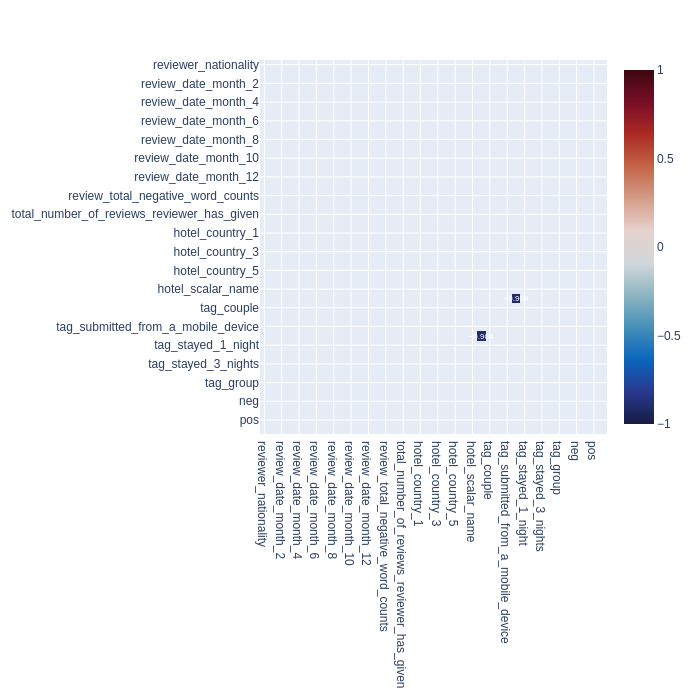

In [53]:
# корреляция признаков (оставляем только сильную связь для наглядности)
pivot = data_result.corr(numeric_only=True).round(3)
pivot = pivot.drop(['sample', 'reviewer_score'], axis=0)
pivot = pivot.drop(['sample', 'reviewer_score'], axis=1)

for col in pivot:
    pivot[col] = pivot[col].apply(lambda x: np.nan if (abs(x) < 0.85 or x == 1) else x)
# for col in pivot:
#     pivot = pivot.dropna(how='all')
#     pivot = pivot.dropna(how='all', axis='columns')

fig = px.imshow(pivot,
                text_auto=True,
                height=700,
                color_continuous_scale='balance',
                aspect="auto",
                zmin=-1,
                zmax=1
                )

fig.show('png')

Обнаруживаем мультиколлинеарность между признаками tag_leisure_trip и tag_business_trip. Удаляем tag_business_trip.

In [54]:
data_result.drop(['tag_business_trip'], axis=1, inplace=True)

In [55]:
data_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 41 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   reviewer_nationality                        515738 non-null  int64  
 1   reviewer_score                              515738 non-null  float64
 2   sample                                      515738 non-null  int64  
 3   review_date_month_1                         515738 non-null  int64  
 4   review_date_month_2                         515738 non-null  int64  
 5   review_date_month_3                         515738 non-null  int64  
 6   review_date_month_4                         515738 non-null  int64  
 7   review_date_month_5                         515738 non-null  int64  
 8   review_date_month_6                         515738 non-null  int64  
 9   review_date_month_7                         515738 non-null  int64  
 

# ОБУЧЕНИЕ МОДЕЛИ

In [56]:
# Теперь выделим тестовую часть
train_data = data_result.query('sample==1').drop(['sample'], axis=1)
test_data = data_result.query('sample==0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [57]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [58]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 40), (386803, 40), (386803, 39), (309442, 39), (77361, 39))

In [59]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [60]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [61]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    3.0s finished


In [62]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.8727328300651057


In [63]:
# оцениваем точность прогноза
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) # Этот коэффициент соответствует верхнему, если его вычесть из единицы.

print('MAPE:', mean_absolute_percentage_error(y_test, y_pred)) 

MAPE: 0.12463561935519227


In [64]:
metrics.mean_absolute_error(y_test, y_pred) + mean_absolute_percentage_error(y_test, y_pred)

0.997368449420298

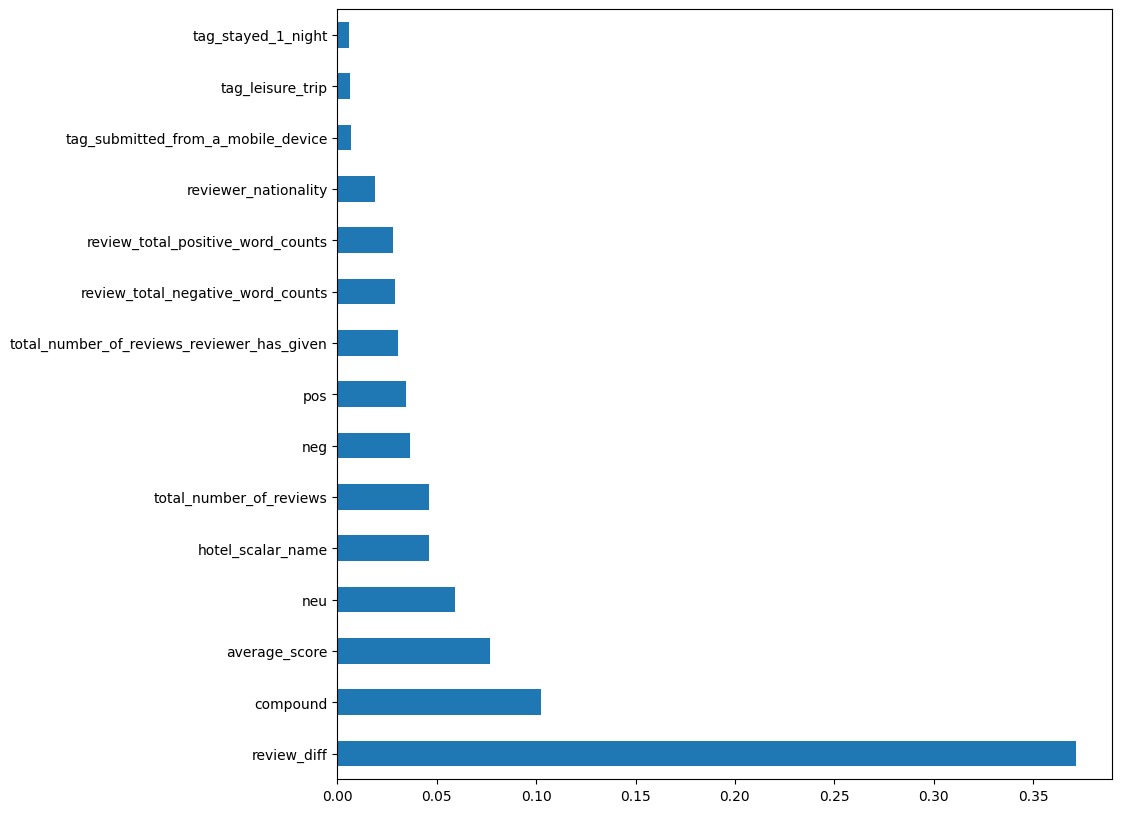

In [65]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh');

In [66]:
test_data.sample(10)

,reviewer_nationality,reviewer_score,review_date_month_1,review_date_month_2,review_date_month_3,review_date_month_4,review_date_month_5,review_date_month_6,review_date_month_7,review_date_month_8,...,tag_stayed_1_night,tag_solo_traveler,tag_stayed_3_nights,tag_family_with_young_children,tag_group,review_diff,neg,neu,pos,compound
443308,8,0.0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,53,0.000,1.453,0.547,0.9260
499894,8,0.0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,42,0.000,0.472,0.528,0.7717
441899,7,0.0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,-25,0.000,1.000,0.000,0.0000
507045,5,0.0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,-65,0.286,1.714,0.000,0.0000
390222,6,0.0,0,0,0,0,0,1,0,0,...,1,1,0,0,0,-29,0.482,0.518,0.000,0.0000
401589,10,0.0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,29,0.000,1.000,0.000,0.0000
510874,10,0.0,0,0,0,0,0,0,1,0,...,0,0,1,1,0,-261,0.105,0.772,0.123,0.2500
472829,8,0.0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,30,0.000,0.513,0.487,0.5859
449941,10,0.0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,76,0.394,1.428,0.178,0.2176
415262,2,0.0,0,0,0,0,0,1,0,0,...,1,1,0,0,0,-134,0.097,1.397,0.506,0.1845


In [67]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [68]:
sample_submission

,reviewer_score,id
0,8.685,488440
1,7.578,274649
2,7.929,374688
3,9.592,404352
4,9.565,451596
...,...,...
128930,9.219,495812
128931,9.468,315577
128932,8.318,511968
128933,9.614,303386


In [69]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    5.9s finished


In [70]:
predict_submission

array([8.731, 7.56 , 7.955, ..., 8.356, 9.62 , 7.466])

In [71]:
list(sample_submission)

['reviewer_score', 'id']

In [72]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.731,488440
1,7.560,274649
2,7.955,374688
3,9.566,404352
4,9.549,451596
5,9.262,302161
6,8.018,317079
7,7.819,13963
8,8.780,159785
9,7.996,195089
